# Importing Libraries

In [ ]:
!pip install wordcloud
!pip install nltk

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import pandas as pd 
import numpy as np 
import time
import pickle

#For Text Cleaning
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')

#For EDA
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

#For text vectorizing
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from gensim import corpora
from gensim import models
import random

#For naives bayes DF
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix   

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for bag-of-words
from sklearn import feature_extraction, model_selection, manifold, preprocessing
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
import tensorflow

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#Relevant Functions

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
def makeROC(classifiers, title, rocX_test, rocy_test):
    # Define a result table as a DataFrame
    result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

    # Train the models and record the results
    for cls in classifiers:
        model = cls
        yproba = model.predict_proba(rocX_test)[::,1]

        fpr, tpr, _ = roc_curve(rocy_test,  yproba)
        auc = roc_auc_score(rocy_test, yproba)

        result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                            'fpr':fpr, 
                                            'tpr':tpr, 
                                            'auc':auc}, ignore_index=True)

    # Set name of the classifiers as index labels
    result_table.set_index('classifiers', inplace=True)
    fig = plt.figure(figsize=(8,6))

    for i in result_table.index:
        plt.plot(result_table.loc[i]['fpr'], 
                 result_table.loc[i]['tpr'], 
                 label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))

    plt.plot([0,1], [0,1], color='orange', linestyle='--')

    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("False Positive Rate", fontsize=15)

    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positive Rate", fontsize=15)

    plt.title(('ROC Curve Analysis '+title), fontweight='bold', fontsize=15)
    plt.legend(prop={'size':13}, loc='lower right')

    plt.show()
    

# Classification

In [ ]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df['text'],df['label'],train_size= 0.45, stratify=df['label'], random_state=0)

In [ ]:
fulllist = []
for i in df['text']:
    fulllist.append(i)

#Set maxfeatures to 5000 maybe next time
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(fulllist)
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

## Gridsearch Optimization (Please Do not run this section)

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

def randomsearchmethod(clf, param_dist, n_iter_search):

    # Utility function to report best scores
    def report(results, n_top=3):
        for i in range(1, n_top + 1):
            candidates = np.flatnonzero(results['rank_test_score'] == i)
            for candidate in candidates:
                print("Model with rank: {0}".format(i))
                print("Mean validation score: {0:.3f} (std: {1:.3f})"
                      .format(results['mean_test_score'][candidate],
                              results['std_test_score'][candidate]))
                print("Parameters: {0}".format(results['params'][candidate]))
                print("")

    random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                       n_iter=n_iter_search)

    random_search.fit(Train_X_Tfidf,Train_Y)
    report(random_search.cv_results_)
    

### Stochastic Gradient Descent

In [ ]:
SGD = SGDClassifier(loss='log', penalty='l2', alpha=1e-3, n_iter_no_change=5)

param_dist = {
    'penalty': ['elasticnet','l2'],
    'alpha': [10 ** x for x in range(-6, 1)],
    'l1_ratio': [0, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1],
}

n_iter_search = 20

randomsearchmethod(SGD,param_dist, n_iter_search)

Model with rank: 1
Mean validation score: 0.946 (std: 0.002)
Parameters: {'penalty': 'l2', 'l1_ratio': 0.9, 'alpha': 1e-05}

Model with rank: 2
Mean validation score: 0.945 (std: 0.002)
Parameters: {'penalty': 'elasticnet', 'l1_ratio': 0.1, 'alpha': 1e-05}

Model with rank: 3
Mean validation score: 0.945 (std: 0.002)
Parameters: {'penalty': 'l2', 'l1_ratio': 0.1, 'alpha': 1e-05}



### AdaBoost

In [ ]:
ADA = AdaBoostClassifier()

param_dist = {
    'learning_rate' : [0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1],
    'n_estimators': [100,200,300,400],
    'base_estimator': [DecisionTreeClassifier(random_state=0, max_depth=1), DecisionTreeClassifier(random_state=0, max_depth=2),DecisionTreeClassifier(random_state=0, max_depth=3)]
}

n_iter_search = 3

randomsearchmethod(ADA,param_dist, n_iter_search)

Model with rank: 1
Mean validation score: 0.937 (std: 0.006)
Parameters: {'n_estimators': 300, 'learning_rate': 0.95, 'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')}

Model with rank: 2
Mean validation score: 0.937 (std: 0.004)
Parameters: {'n_estimators': 300, 'learning_rate': 0.9, 'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                

### RandomForest

In [ ]:
RF = RandomForestClassifier()

param_dist = {
    'max_depth': [5,10,15,20,25],
    'n_estimators': [70,80,85,90,100]
}

n_iter_search = 20

randomsearchmethod(RF,param_dist, n_iter_search)

Model with rank: 1
Mean validation score: 0.904 (std: 0.006)
Parameters: {'n_estimators': 100, 'max_depth': 25}

Model with rank: 2
Mean validation score: 0.902 (std: 0.007)
Parameters: {'n_estimators': 70, 'max_depth': 25}

Model with rank: 3
Mean validation score: 0.901 (std: 0.008)
Parameters: {'n_estimators': 85, 'max_depth': 25}



### XGBoost Classifier

In [ ]:
XGB = XGBClassifier()

param_dist = {
    'max_depth': [0,5,10,15,20,25],
    'n_estimators': [50, 100, 150, 200, 250],
    'reg_alpha': [0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1]
}

n_iter_search = 3

randomsearchmethod(XGB,param_dist, n_iter_search)

Model with rank: 1
Mean validation score: 0.945 (std: 0.005)
Parameters: {'reg_alpha': 0.8, 'n_estimators': 200, 'max_depth': 10}

Model with rank: 2
Mean validation score: 0.945 (std: 0.006)
Parameters: {'reg_alpha': 0.05, 'n_estimators': 200, 'max_depth': 15}

Model with rank: 3
Mean validation score: 0.942 (std: 0.005)
Parameters: {'reg_alpha': 0.8, 'n_estimators': 150, 'max_depth': 25}



## Other forms of classification; eg. NN, SVM

### Support Vector Classifier

In [ ]:
'''
from sklearn.svm import SVC

SV = SVC(kernel='linear').fit(Train_X_Tfidf, Train_Y)

predictions_SV = SV.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy

print("****SVC Report****")
print("XGBoost Accuracy:",metrics.accuracy_score(Test_Y, predictions_SV))
print('\nClasification report:\n', classification_report(Test_Y, predictions_SV))
print('\nConfussion matrix:\n',confusion_matrix(Test_Y, predictions_SV)  )
'''

### Word2Vec Neural Network (Please do not rerun thanks)

#### Using Genism Api to draw pretrained news Word2Vec model

In [ ]:
#nlp = gensim_api.load("word2vec-google-news-300")
## create list of lists of unigrams
corpus = Train_X

lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)

nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=300, window=8, min_count=1, sg=1, iter=30)

## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=15, padding="post", truncating="post")

corpus = Test_X

## create list of n-grams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    
## detect common bigrams using the fitted detectors
lst_corpus = list(bigrams_detector[lst_corpus])
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=15,
             padding="post", truncating="post")

## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


#### Declare Neural Network Layers

In [ ]:
## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
x_in = layers.Input(shape=(15,))
## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=15, trainable=False)(x_in)
## apply attention
x = attention_layer(x, neurons=15)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.3, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.3))(x)
## final dense layers
x = layers.Dense(32, activation='relu')(x)
y_out = layers.Dense(2, activation='softmax')(x)
## compile
NNmodel = models.Model(x_in, y_out)
NNmodel.compile(loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(),
              optimizer='adam', metrics=['accuracy'])

NNmodel.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 15, 300)      22216500    input_3[0][0]                    
__________________________________________________________________________________________________
permute_2 (Permute)             (None, 300, 15)      0           embedding_2[0][0]                
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 300, 15)      240         permute_2[0][0]                  
____________________________________________________________________________________________

#### Run and discover Epoch training and validation loss

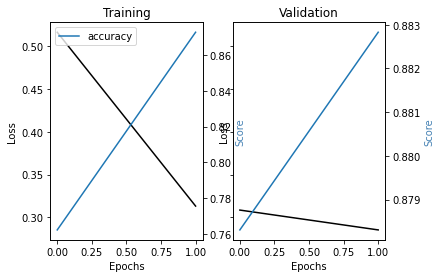

In [ ]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(Train_Y))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in Train_Y])
## train
training = NNmodel.fit(x=X_train, y=y_train, batch_size=256, epochs=2, shuffle=True, verbose=0, validation_split=0.2)
## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

## Prediction
predicted_prob = NNmodel.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]

#### LSTM Accuracy Report

In [ ]:
print("****LSTM Report****")
print("LSTM Accuracy:",metrics.accuracy_score(Test_Y, predicted))
print('\nClasification report:\n', classification_report(Test_Y, predicted))
print('\nConfussion matrix:\n',confusion_matrix(Test_Y, predicted)  )

****LSTM Report****
LSTM Accuracy: 0.8300857365549493

Clasification report:
               precision    recall  f1-score   support

           0       0.75      0.95      0.84     12005
           1       0.95      0.72      0.82     13655

    accuracy                           0.83     25660
   macro avg       0.85      0.84      0.83     25660
weighted avg       0.85      0.83      0.83     25660


Confussion matrix:
 [[11433   572]
 [ 3788  9867]]


## Classification Accuracy Report

In [ ]:
# replace ngram_range = (1,2) for bigram
NB = MultinomialNB().fit(Train_X_Tfidf,Train_Y)

SGD = SGDClassifier(loss='log', penalty= 'l2', l1_ratio= 0.05, alpha= 1e-05, n_iter_no_change=5).fit(Train_X_Tfidf,Train_Y)

ADA = AdaBoostClassifier(n_estimators= 300, learning_rate= 0.2, base_estimator= DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,)).fit(Train_X_Tfidf, Train_Y)

RF = RandomForestClassifier(n_estimators=100, max_depth=25, random_state=0).fit(Train_X_Tfidf, Train_Y)

XGB = XGBClassifier(n_estimators = 200, max_depth=15, reg_alpha=0.05).fit(Train_X_Tfidf, Train_Y)

# Save to file in the current working directory
pkl_filename = "BaseTFIDFNB.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(NB, file)

pkl_filename = "BaseTFIDFSGD.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(SGD, file)

pkl_filename = "BaseTFIDFADA.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(ADA, file)

pkl_filename = "BaseTFIDFRF.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(RF, file)

pkl_filename = "BaseTFIDFXGB.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(XGB, file)

In [ ]:
# Load from file
pkl_filename = "BaseTFIDFNB.pkl"
with open(pkl_filename, 'rb') as file:
    NB = pickle.load(file)
predictions_NB = NB.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("****NB Report****")
print("MultinomialNB Accuracy:",metrics.accuracy_score(Test_Y, predictions_NB))
print('\nClasification report:\n', classification_report(Test_Y, predictions_NB))
print('\nConfussion matrix:\n',confusion_matrix(Test_Y, predictions_NB)  )
print()
print("*"*36)

# Load from file
pkl_filename = "BaseTFIDFSGD.pkl"
with open(pkl_filename, 'rb') as file:
    SGD = pickle.load(file)
# predict the labels on validation dataset
predictions_SGD = SGD.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("****SGD Report****")
print("SGD Accuracy:",metrics.accuracy_score(Test_Y, predictions_SGD))
print('\nClasification report:\n', classification_report(Test_Y, predictions_SGD))
print('\nConfussion matrix:\n',confusion_matrix(Test_Y, predictions_SGD))
print()
print("*"*36)

# Load from file
pkl_filename = "BaseTFIDFADA.pkl"
with open(pkl_filename, 'rb') as file:
    ADA = pickle.load(file)
predictions_ADA = ADA.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("****ADABoost Report****")
print("AdaBoostClassifier Accuracy:",metrics.accuracy_score(Test_Y, predictions_ADA))
print('\nClasification report:\n', classification_report(Test_Y, predictions_ADA))
print('\nConfussion matrix:\n',confusion_matrix(Test_Y, predictions_ADA) )
print()
print("*"*36)

# Load from file
pkl_filename = "BaseTFIDFRF.pkl"
with open(pkl_filename, 'rb') as file:
    RF = pickle.load(file)
predictions_RF = RF.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("****RF Report****")
print("RandomForest Accuracy:",metrics.accuracy_score(Test_Y, predictions_RF))
print('\nClasification report:\n', classification_report(Test_Y, predictions_RF))
print('\nConfussion matrix:\n',confusion_matrix(Test_Y, predictions_RF)  )
print()
print("*"*36)

# Load from file
pkl_filename = "BaseTFIDFXGB.pkl"
with open(pkl_filename, 'rb') as file:
    XGB = pickle.load(file)
predictions_XGB = XGB.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("****XGB Report****")
print("XGBoost Accuracy:",metrics.accuracy_score(Test_Y, predictions_XGB))
print('\nClasification report:\n', classification_report(Test_Y, predictions_XGB))
print('\nConfussion matrix:\n',confusion_matrix(Test_Y, predictions_XGB)  )

****NB Report****
MultinomialNB Accuracy: 0.8798129384255651

Clasification report:
               precision    recall  f1-score   support

           0       0.86      0.89      0.87     12005
           1       0.90      0.87      0.89     13655

    accuracy                           0.88     25660
   macro avg       0.88      0.88      0.88     25660
weighted avg       0.88      0.88      0.88     25660


Confussion matrix:
 [[10698  1307]
 [ 1777 11878]]

************************************
****SGD Report****
SGD Accuracy: 0.939867498051442

Clasification report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.94     12005
           1       0.95      0.94      0.94     13655

    accuracy                           0.94     25660
   macro avg       0.94      0.94      0.94     25660
weighted avg       0.94      0.94      0.94     25660


Confussion matrix:
 [[11269   736]
 [  807 12848]]

************************************
****AD

## Base Model ROC Comparison


************************************


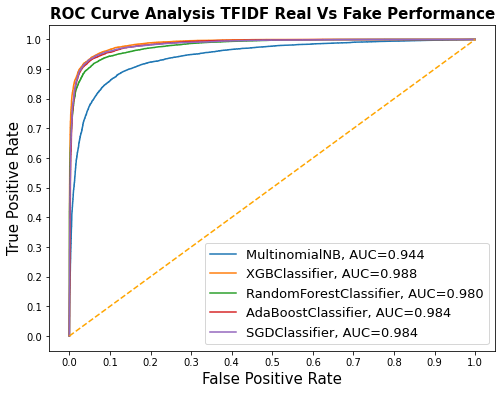

In [ ]:
print()
print("*"*36)

makeROC([NB, XGB, RF, ADA, SGD],"TFIDF Real Vs Fake Performance", Test_X_Tfidf, Test_Y)

# Classification with Sentiment, Topic, Entity Data

## Importing Sentiment, Topic, and Entity Data

In [ ]:
dfemotion = pd.read_excel("sample_data/pos_groupings_vader_emotion.xlsx")
dfemotion = dfemotion.drop(['text','title','Unnamed: 0','index','label_y','compound'], axis=1)
dftopic = pd.read_excel("sample_data/topic_distribution_14.xlsx")
dftopic = dftopic.drop(['Unnamed: 0','Text'], axis=1)

entity = pd.read_csv("sample_data/Entity_final.csv")
entity = entity.drop(['title','text','label','index','person entities','organisation entities','location entities'], axis=1)

## Combining Text with Topic probabilities, and Entity with Sentiment and POS Data

In [ ]:
#Split text set to 20k rows
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df['text'],df['label'],train_size= 0.45, stratify=df['label'], random_state=0)

#TFIDF Vectorize New Sample Set
fulllist = []
for i in Train_X:
    fulllist.append(i)

Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(fulllist)
Train_X_Tfidf = Tfidf_vect.transform(Train_X)

#Convert to dataframe
Train_X_df = pd.DataFrame(Train_X_Tfidf.toarray(), columns=Tfidf_vect.get_feature_names())
Train_Y = Train_Y.fillna(0)

#Combine dataframes
dftopic = pd.concat([dftopic, Train_X_df], axis=1)
dfemotion = pd.concat([dfemotion, entity[['person entity count', 'organisation entity count' , 'location entity count']]], axis=1)
save_y = Train_Y.copy()

#Create test and train text set
Train_X_Topic, Test_X_Topic, Train_Y_Topic, Test_Y_Topic = model_selection.train_test_split(dftopic,Train_Y, train_size= 0.4, stratify=Train_Y, random_state=0)
Train_X_Emotion, Test_X_Emotion, Train_Y_Emotion, Test_Y_Emotion = model_selection.train_test_split(dfemotion,Train_Y, train_size= 0.4, stratify=Train_Y, random_state=0)
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(Train_X_df,Train_Y,train_size= 0.4, stratify=Train_Y, random_state=0)

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

def randomsearchmethod(clf, param_dist, n_iter_search, Train_X_Tfidf, Train_Y):

    # Utility function to report best scores
    def report(results, n_top=3):
        for i in range(1, n_top + 1):
            candidates = np.flatnonzero(results['rank_test_score'] == i)
            for candidate in candidates:
                print("Model with rank: {0}".format(i))
                print("Mean validation score: {0:.3f} (std: {1:.3f})"
                      .format(results['mean_test_score'][candidate],
                              results['std_test_score'][candidate]))
                print("Parameters: {0}".format(results['params'][candidate]))
                print("")

    random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                       n_iter=n_iter_search)

    random_search.fit(Train_X_Tfidf,Train_Y)
    report(random_search.cv_results_)
    

## Topic Data Classification

### Topic Data Optimization

In [ ]:
print("*"*36)
print("SGD Optimization")
SGD = SGDClassifier(loss='log', penalty='l2', alpha=1e-3, n_iter_no_change=5)
param_dist = {
    'penalty': ['elasticnet','l2'],
    'alpha': [10 ** x for x in range(-6, 1)],
    'l1_ratio': [0, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1],
}
n_iter_search = 20
randomsearchmethod(SGD,param_dist, n_iter_search, Train_X_Topic,Train_Y_Topic)


************************************
SGD Optimization
Model with rank: 1
Mean validation score: 0.932 (std: 0.006)
Parameters: {'penalty': 'elasticnet', 'l1_ratio': 0.1, 'alpha': 0.0001}

Model with rank: 2
Mean validation score: 0.929 (std: 0.005)
Parameters: {'penalty': 'l2', 'l1_ratio': 0.1, 'alpha': 0.0001}

Model with rank: 3
Mean validation score: 0.924 (std: 0.005)
Parameters: {'penalty': 'l2', 'l1_ratio': 0.1, 'alpha': 1e-05}




In [ ]:
print("*"*36)
print("ADABoost Optimization")
ADA = AdaBoostClassifier()
param_dist = {
    'learning_rate' : [0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1],
    'n_estimators': [100,200,300,400],
    'base_estimator': [DecisionTreeClassifier(random_state=0, max_depth=1), DecisionTreeClassifier(random_state=0, max_depth=2),DecisionTreeClassifier(random_state=0, max_depth=3)]
}
n_iter_search = 2
randomsearchmethod(ADA,param_dist, n_iter_search, Train_X_Topic,Train_Y_Topic)

************************************
ADABoost Optimization
Model with rank: 1
Mean validation score: 0.930 (std: 0.005)
Parameters: {'n_estimators': 300, 'learning_rate': 0.1, 'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')}

Model with rank: 2
Mean validation score: 0.925 (std: 0.007)
Parameters: {'n_estimators': 300, 'learning_rate': 0.9, 'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                      

In [ ]:
#Restart this one it ran on emotion
print("*"*36)
print("Random Forest Optimization")
RF = RandomForestClassifier()
param_dist = {
    'max_depth': [5,10,15,20,25,30,35,40],
    'n_estimators': [70,80,85,90,100,110,120,130,140]
}
n_iter_search = 20
randomsearchmethod(RF,param_dist, n_iter_search, Train_X_Topic,Train_Y_Topic)

************************************
Random Forest Optimization
Model with rank: 1
Mean validation score: 0.924 (std: 0.005)
Parameters: {'n_estimators': 110, 'max_depth': 40}

Model with rank: 2
Mean validation score: 0.924 (std: 0.005)
Parameters: {'n_estimators': 120, 'max_depth': 35}

Model with rank: 3
Mean validation score: 0.923 (std: 0.006)
Parameters: {'n_estimators': 90, 'max_depth': 30}



In [ ]:
print("*"*36)
print("XGBoost Optimization")
XGB = XGBClassifier()
param_dist = {
    'max_depth': [0,5,10,15,20,25],
    'n_estimators': [50, 100, 150, 200, 250],
    'reg_alpha': [0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1]
}
n_iter_search = 2
randomsearchmethod(XGB,param_dist, n_iter_search, Train_X_Topic,Train_Y_Topic)

************************************
XGBoost Optimization
Model with rank: 1
Mean validation score: 0.937 (std: 0.005)
Parameters: {'reg_alpha': 1, 'n_estimators': 250, 'max_depth': 5}

Model with rank: 2
Mean validation score: 0.532 (std: 0.000)
Parameters: {'reg_alpha': 0.2, 'n_estimators': 200, 'max_depth': 0}



### Topic Data Saving Fitted Models

In [ ]:
TopicADA = AdaBoostClassifier(n_estimators= 350, learning_rate= 0.1, base_estimator= DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,)).fit(Train_X_Topic,Train_Y_Topic)

pkl_filename = "TopicTFIDFADA.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(TopicADA, file)

In [ ]:
# replace ngram_range = (1,2) for bigram
TopicNB = MultinomialNB().fit(Train_X_Topic,Train_Y_Topic)

TopicSGD = SGDClassifier(loss='log', penalty= 'elasticnet', l1_ratio= 0.1, alpha= 0.0001, n_iter_no_change=5).fit(Train_X_Topic,Train_Y_Topic)

TopicADA = AdaBoostClassifier(n_estimators= 350, learning_rate= 0.1, base_estimator= DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,)).fit(Train_X_Topic,Train_Y_Topic)

TopicRF = RandomForestClassifier(n_estimators=140, max_depth=40, random_state=0).fit(Train_X_Topic,Train_Y_Topic)

TopicXGB = XGBClassifier(n_estimators = 120, max_depth=10, reg_alpha=0.8).fit(Train_X_Topic,Train_Y_Topic)

# Save to file in the current working directory
pkl_filename = "TopicTFIDFNB.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(TopicNB, file)

pkl_filename = "TopicTFIDFSGD.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(TopicSGD, file)

pkl_filename = "TopicTFIDFADA.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(TopicADA, file)

pkl_filename = "TopicTFIDFRF.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(TopicRF, file)

pkl_filename = "TopicTFIDFXGB.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(TopicXGB, file)

### Topic Data Accuracy Report

In [ ]:
# Load from file
pkl_filename = "TopicTFIDFNB.pkl"
with open(pkl_filename, 'rb') as file:
    TopicNB = pickle.load(file)

# Load from file
pkl_filename = "TopicTFIDFSGD.pkl"
with open(pkl_filename, 'rb') as file:
    TopicSGD = pickle.load(file)

# Load from file
pkl_filename = "TopicTFIDFADA.pkl"
with open(pkl_filename, 'rb') as file:
    TopicADA = pickle.load(file)

# Load from file
pkl_filename = "TopicTFIDFRF.pkl"
with open(pkl_filename, 'rb') as file:
    TopicRF = pickle.load(file)

# Load from file
pkl_filename = "TopicTFIDFXGB.pkl"
with open(pkl_filename, 'rb') as file:
    TopicXGB = pickle.load(file)

predictions_NB = TopicNB.predict(Test_X_Topic)
# Use accuracy_score function to get the accuracy
print("****NB Report****")
print("MultinomialNB Accuracy:",metrics.accuracy_score(Test_Y_Topic, predictions_NB))
print('\nClasification report:\n', classification_report(Test_Y_Topic, predictions_NB))
print('\nConfussion matrix:\n',confusion_matrix(Test_Y_Topic, predictions_NB)  )
print()
print("*"*36)


# predict the labels on validation dataset
predictions_SGD = TopicSGD.predict(Test_X_Topic)
# Use accuracy_score function to get the accuracy
print("****SGD Report****")
print("SGD Accuracy:",metrics.accuracy_score(Test_Y_Topic, predictions_SGD))
print('\nClasification report:\n', classification_report(Test_Y_Topic, predictions_SGD))
print('\nConfussion matrix:\n',confusion_matrix(Test_Y_Topic, predictions_SGD))
print()
print("*"*36)


predictions_ADA = TopicADA.predict(Test_X_Topic)
# Use accuracy_score function to get the accuracy
print("****ADABoost Report****")
print("AdaBoostClassifier Accuracy:",metrics.accuracy_score(Test_Y_Topic, predictions_ADA))
print('\nClasification report:\n', classification_report(Test_Y_Topic, predictions_ADA))
print('\nConfussion matrix:\n',confusion_matrix(Test_Y_Topic, predictions_ADA) )
print()
print("*"*36)


predictions_RF = TopicRF.predict(Test_X_Topic)
# Use accuracy_score function to get the accuracy
print("****RF Report****")
print("RandomForest Accuracy:",metrics.accuracy_score(Test_Y_Topic, predictions_RF))
print('\nClasification report:\n', classification_report(Test_Y_Topic, predictions_RF))
print('\nConfussion matrix:\n',confusion_matrix(Test_Y_Topic, predictions_RF)  )
print()
print("*"*36)


predictions_XGB = TopicXGB.predict(Test_X_Topic)
# Use accuracy_score function to get the accuracy
print("****XGB Report****")
print("XGBoost Accuracy:",metrics.accuracy_score(Test_Y_Topic, predictions_XGB))
print('\nClasification report:\n', classification_report(Test_Y_Topic, predictions_XGB))
print('\nConfussion matrix:\n',confusion_matrix(Test_Y_Topic, predictions_XGB)  )

****NB Report****
MultinomialNB Accuracy: 0.8802000635122261

Clasification report:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87      5893
           1       0.89      0.88      0.89      6703

    accuracy                           0.88     12596
   macro avg       0.88      0.88      0.88     12596
weighted avg       0.88      0.88      0.88     12596


Confussion matrix:
 [[5200  693]
 [ 816 5887]]

************************************
****SGD Report****
SGD Accuracy: 0.9270403302635757

Clasification report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92      5893
           1       0.92      0.94      0.93      6703

    accuracy                           0.93     12596
   macro avg       0.93      0.93      0.93     12596
weighted avg       0.93      0.93      0.93     12596


Confussion matrix:
 [[5379  514]
 [ 405 6298]]

************************************
****ADABoost 

### Topic Model ROC Comparison

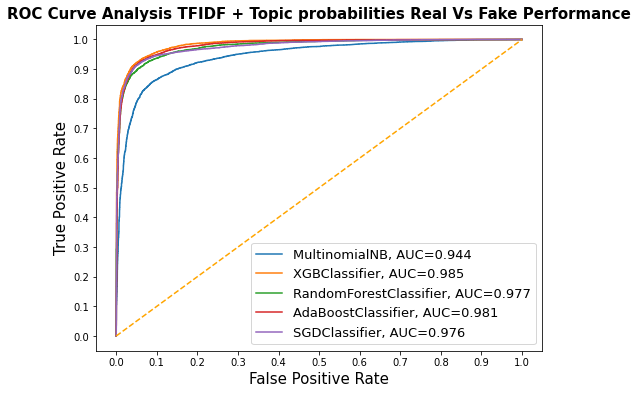

In [ ]:
makeROC([TopicNB, TopicXGB, TopicRF, TopicADA, TopicSGD],"TFIDF + Topic probabilities Real Vs Fake Performance", Test_X_Topic, Test_Y_Topic)

## Sentiment Data Classification

### Sentiment Data Optimization

In [ ]:
print("*"*36)
print("SGD Optimization")
SGD = SGDClassifier(loss='log', penalty='l2', alpha=1e-3, n_iter_no_change=5)
param_dist = {
    'penalty': ['elasticnet','l2'],
    'alpha': [10 ** x for x in range(-6, 1)],
    'l1_ratio': [0, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1],
}
n_iter_search = 20
randomsearchmethod(SGD,param_dist, n_iter_search, Train_X_Emotion,Train_Y_Emotion)

************************************
SGD Optimization
Model with rank: 1
Mean validation score: 0.721 (std: 0.036)
Parameters: {'penalty': 'elasticnet', 'l1_ratio': 0.9, 'alpha': 0.0001}

Model with rank: 2
Mean validation score: 0.706 (std: 0.022)
Parameters: {'penalty': 'elasticnet', 'l1_ratio': 0.1, 'alpha': 0.1}

Model with rank: 3
Mean validation score: 0.693 (std: 0.040)
Parameters: {'penalty': 'elasticnet', 'l1_ratio': 0.8, 'alpha': 0.001}



In [ ]:
print("*"*36)
print("ADABoost Optimization")
ADA = AdaBoostClassifier()
param_dist = {
    'learning_rate' : [0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1],
    'n_estimators': [100,200,300,400],
    'base_estimator': [DecisionTreeClassifier(random_state=0, max_depth=1), DecisionTreeClassifier(random_state=0, max_depth=2),DecisionTreeClassifier(random_state=0, max_depth=3)]
}
n_iter_search = 20
randomsearchmethod(ADA,param_dist, n_iter_search, Train_X_Emotion,Train_Y_Emotion)

************************************
ADABoost Optimization
Model with rank: 1
Mean validation score: 0.790 (std: 0.013)
Parameters: {'n_estimators': 400, 'learning_rate': 0.1, 'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')}

Model with rank: 2
Mean validation score: 0.789 (std: 0.012)
Parameters: {'n_estimators': 300, 'learning_rate': 0.2, 'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                      

In [ ]:
print("*"*36)
print("Random Forest Optimization")
RF = RandomForestClassifier()
param_dist = {
    'max_depth': [5,10,15,20,25,30,35,40],
    'n_estimators': [70,80,85,90,100,110,120,130,140]
}
n_iter_search = 20
randomsearchmethod(RF,param_dist, n_iter_search, Train_X_Emotion,Train_Y_Emotion)

************************************
Random Forest Optimization
Model with rank: 1
Mean validation score: 0.795 (std: 0.005)
Parameters: {'n_estimators': 130, 'max_depth': 25}

Model with rank: 2
Mean validation score: 0.794 (std: 0.011)
Parameters: {'n_estimators': 130, 'max_depth': 30}

Model with rank: 3
Mean validation score: 0.793 (std: 0.010)
Parameters: {'n_estimators': 110, 'max_depth': 35}



In [ ]:
print("*"*36)
print("XGBoost Optimization")
XGB = XGBClassifier()
param_dist = {
    'max_depth': [0,5,10,15,20,25],
    'n_estimators': [50, 100, 150, 200, 250],
    'reg_alpha': [0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1]
}
n_iter_search = 20
randomsearchmethod(XGB,param_dist, n_iter_search, Train_X_Emotion,Train_Y_Emotion)

************************************
XGBoost Optimization
Model with rank: 1
Mean validation score: 0.799 (std: 0.007)
Parameters: {'reg_alpha': 0.05, 'n_estimators': 150, 'max_depth': 20}

Model with rank: 2
Mean validation score: 0.798 (std: 0.008)
Parameters: {'reg_alpha': 0.2, 'n_estimators': 250, 'max_depth': 20}

Model with rank: 3
Mean validation score: 0.798 (std: 0.008)
Parameters: {'reg_alpha': 0.95, 'n_estimators': 250, 'max_depth': 20}



### Sentiment Data Saving Fitted Models

In [ ]:
# replace ngram_range = (1,2) for bigram
EmotionNB = MultinomialNB().fit(Train_X_Emotion,Train_Y_Emotion)

EmotionSGD = SGDClassifier(loss='log', penalty= 'elasticnet', l1_ratio= 0.8, alpha= 1e-05, n_iter_no_change=5).fit(Train_X_Emotion,Train_Y_Emotion)

EmotionADA = AdaBoostClassifier(n_estimators= 400, learning_rate= 0.1, base_estimator= DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,)).fit(Train_X_Emotion,Train_Y_Emotion)

EmotionRF = RandomForestClassifier(n_estimators=130, max_depth=40, random_state=0).fit(Train_X_Emotion,Train_Y_Emotion)

EmotionXGB = XGBClassifier(n_estimators = 250, max_depth=20, reg_alpha=0.05).fit(Train_X_Emotion,Train_Y_Emotion)

# Save to file in the current working directory
pkl_filename = "EmotionNB.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(EmotionNB, file)

pkl_filename = "EmotionSGD.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(EmotionSGD, file)

pkl_filename = "EmotionADA.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(EmotionADA, file)

pkl_filename = "EmotionRF.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(EmotionRF, file)

pkl_filename = "EmotionXGB.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(EmotionXGB, file)

### Sentiment Data Accuracy Report

In [ ]:
# Load from file
pkl_filename = "EmotionNB.pkl"
with open(pkl_filename, 'rb') as file:
    EmotionNB = pickle.load(file)

# Load from file
pkl_filename = "EmotionSGD.pkl"
with open(pkl_filename, 'rb') as file:
    EmotionSGD = pickle.load(file)

# Load from file
pkl_filename = "EmotionADA.pkl"
with open(pkl_filename, 'rb') as file:
    EmotionADA = pickle.load(file)

# Load from file
pkl_filename = "EmotionRF.pkl"
with open(pkl_filename, 'rb') as file:
    EmotionRF = pickle.load(file)

# Load from file
pkl_filename = "EmotionXGB.pkl"
with open(pkl_filename, 'rb') as file:
    EmotionXGB = pickle.load(file)

predictions_NB = EmotionNB.predict(Test_X_Emotion)
# Use accuracy_score function to get the accuracy
print("****NB Report****")
print("MultinomialNB Accuracy:",metrics.accuracy_score(Test_Y_Emotion, predictions_NB))
print('\nClasification report:\n', classification_report(Test_Y_Emotion, predictions_NB))
print('\nConfussion matrix:\n',confusion_matrix(Test_Y_Emotion, predictions_NB)  )
print()
print("*"*36)


# predict the labels on validation dataset
predictions_SGD = EmotionSGD.predict(Test_X_Emotion)
# Use accuracy_score function to get the accuracy
print("****SGD Report****")
print("SGD Accuracy:",metrics.accuracy_score(Test_Y_Emotion, predictions_SGD))
print('\nClasification report:\n', classification_report(Test_Y_Emotion, predictions_SGD))
print('\nConfussion matrix:\n',confusion_matrix(Test_Y_Emotion, predictions_SGD))
print()
print("*"*36)


predictions_ADA = EmotionADA.predict(Test_X_Emotion)
# Use accuracy_score function to get the accuracy
print("****ADABoost Report****")
print("AdaBoostClassifier Accuracy:",metrics.accuracy_score(Test_Y_Emotion, predictions_ADA))
print('\nClasification report:\n', classification_report(Test_Y_Emotion, predictions_ADA))
print('\nConfussion matrix:\n',confusion_matrix(Test_Y_Emotion, predictions_ADA) )
print()
print("*"*36)


predictions_RF = EmotionRF.predict(Test_X_Emotion)
# Use accuracy_score function to get the accuracy
print("****RF Report****")
print("RandomForest Accuracy:",metrics.accuracy_score(Test_Y_Emotion, predictions_RF))
print('\nClasification report:\n', classification_report(Test_Y_Emotion, predictions_RF))
print('\nConfussion matrix:\n',confusion_matrix(Test_Y_Emotion, predictions_RF)  )
print()
print("*"*36)


predictions_XGB = EmotionXGB.predict(Test_X_Emotion)
# Use accuracy_score function to get the accuracy
print("****XGB Report****")
print("XGBoost Accuracy:",metrics.accuracy_score(Test_Y_Emotion, predictions_XGB))
print('\nClasification report:\n', classification_report(Test_Y_Emotion, predictions_XGB))
print('\nConfussion matrix:\n',confusion_matrix(Test_Y_Emotion, predictions_XGB)  )

****NB Report****
MultinomialNB Accuracy: 0.7137980311209908

Clasification report:
               precision    recall  f1-score   support

           0       0.67      0.75      0.71      5893
           1       0.76      0.68      0.72      6703

    accuracy                           0.71     12596
   macro avg       0.72      0.72      0.71     12596
weighted avg       0.72      0.71      0.71     12596


Confussion matrix:
 [[4438 1455]
 [2150 4553]]

************************************
****SGD Report****
SGD Accuracy: 0.6201174976182915

Clasification report:
               precision    recall  f1-score   support

           0       0.55      0.97      0.70      5893
           1       0.91      0.32      0.47      6703

    accuracy                           0.62     12596
   macro avg       0.73      0.64      0.59     12596
weighted avg       0.74      0.62      0.58     12596


Confussion matrix:
 [[5689  204]
 [4581 2122]]

************************************
****ADABoost 

### Sentiment, POS, and Entity ROC Comparison

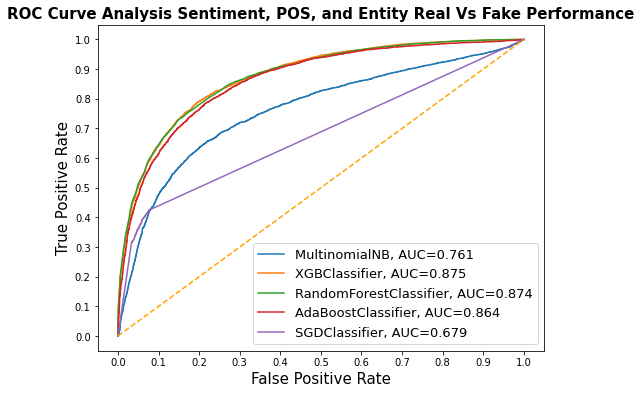

In [ ]:
makeROC([ EmotionNB, EmotionXGB, EmotionRF, EmotionADA, EmotionSGD],"Sentiment, POS, and Entity Real Vs Fake Performance", Test_X_Emotion, Test_Y_Emotion)

### Generalized Model Feature Importance

In [ ]:
# Load from file
pkl_filename = "EmotionADA.pkl"
with open(pkl_filename, 'rb') as file:
    EmotionADA = pickle.load(file)

# Load from file
pkl_filename = "EmotionXGB.pkl"
with open(pkl_filename, 'rb') as file:
    EmotionXGB = pickle.load(file)
    
# Load from file
pkl_filename = "EmotionRF.pkl"
with open(pkl_filename, 'rb') as file:
    EmotionRF = pickle.load(file)

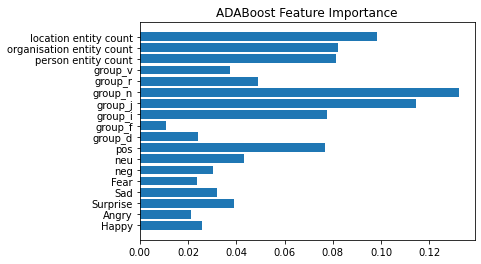

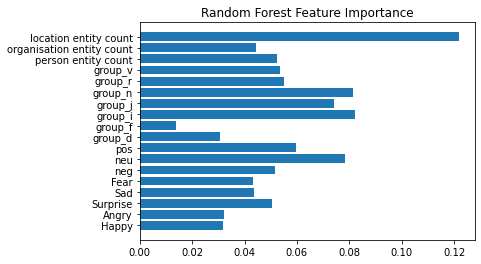

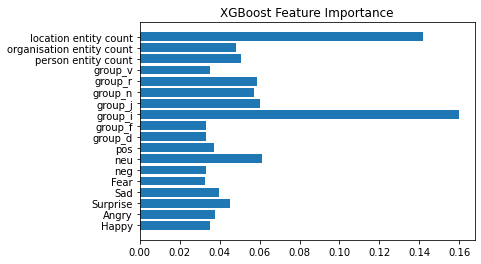

In [ ]:
import matplotlib.pyplot as pyplot
featurenames = EmotionXGB.get_booster().feature_names

pyplot.barh(range(len(EmotionADA.feature_importances_)), EmotionADA.feature_importances_)
plt.yticks(range(len(featurenames)), featurenames)
plt.title('ADABoost Feature Importance')
pyplot.show()

pyplot.barh(range(len(EmotionRF.feature_importances_)), EmotionRF.feature_importances_)
plt.yticks(range(len(featurenames)), featurenames)
plt.title('Random Forest Feature Importance')
pyplot.show()

pyplot.barh(range(len(EmotionXGB.feature_importances_)), EmotionXGB.feature_importances_)
plt.yticks(range(len(featurenames)), featurenames)
plt.title('XGBoost Feature Importance')
pyplot.show()

## TFIDF Classification on extracted Dataset

### TFIDF Extract Accuracy Report

In [ ]:
# replace ngram_range = (1,2) for bigram
TFIDFNB = MultinomialNB().fit(Train_X,Train_Y)

TFIDFSGD = SGDClassifier(loss='log', penalty= 'l2', l1_ratio= 0.05, alpha= 1e-05, n_iter_no_change=5).fit(Train_X,Train_Y)

TFIDFADA = AdaBoostClassifier(n_estimators= 300, learning_rate= 0.2, base_estimator= DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,)).fit(Train_X,Train_Y)

TFIDFRF = RandomForestClassifier(n_estimators=100, max_depth=25, random_state=0).fit(Train_X,Train_Y)

TFIDFXGB = XGBClassifier(n_estimators = 200, max_depth=15, reg_alpha=0.05).fit(Train_X,Train_Y)

# Save to file in the current working directory
pkl_filename = "BaseExtractTFIDFNB.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(TFIDFNB, file)

pkl_filename = "BaseExtractTFIDFSGD.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(TFIDFSGD, file)

pkl_filename = "BaseExtractTFIDFADA.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(TFIDFADA, file)

pkl_filename = "BaseExtractTFIDFRF.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(TFIDFRF, file)

pkl_filename = "BaseExtractTFIDFXGB.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(TFIDFXGB, file)

In [ ]:
# Load from file
pkl_filename = "BaseExtractTFIDFNB.pkl"
with open(pkl_filename, 'rb') as file:
    TFIDFNB = pickle.load(file)

# Load from file
pkl_filename = "BaseExtractTFIDFSGD.pkl"
with open(pkl_filename, 'rb') as file:
    TFIDFSGD = pickle.load(file)

# Load from file
pkl_filename = "BaseExtractTFIDFADA.pkl"
with open(pkl_filename, 'rb') as file:
    TFIDFADA = pickle.load(file)

# Load from file
pkl_filename = "BaseExtractTFIDFRF.pkl"
with open(pkl_filename, 'rb') as file:
    TFIDFRF = pickle.load(file)

# Load from file
pkl_filename = "BaseExtractTFIDFXGB.pkl"
with open(pkl_filename, 'rb') as file:
    TFIDFXGB = pickle.load(file)

# replace ngram_range = (1,2) for bigram
predictions_NB = TFIDFNB.predict(Test_X)
# Use accuracy_score function to get the accuracy
print("****NB Report****")
print("MultinomialNB Accuracy:",metrics.accuracy_score(Test_Y, predictions_NB))
print('\nClasification report:\n', classification_report(Test_Y, predictions_NB))
print('\nConfussion matrix:\n',confusion_matrix(Test_Y, predictions_NB)  )
print()
print("*"*36)


# predict the labels on validation dataset
predictions_SGD = TFIDFSGD.predict(Test_X)
# Use accuracy_score function to get the accuracy
print("****SGD Report****")
print("SGD Accuracy:",metrics.accuracy_score(Test_Y, predictions_SGD))
print('\nClasification report:\n', classification_report(Test_Y, predictions_SGD))
print('\nConfussion matrix:\n',confusion_matrix(Test_Y, predictions_SGD))
print()
print("*"*36)


predictions_ADA = TFIDFADA.predict(Test_X)
# Use accuracy_score function to get the accuracy
print("****ADABoost Report****")
print("AdaBoostClassifier Accuracy:",metrics.accuracy_score(Test_Y, predictions_ADA))
print('\nClasification report:\n', classification_report(Test_Y, predictions_ADA))
print('\nConfussion matrix:\n',confusion_matrix(Test_Y, predictions_ADA) )
print()
print("*"*36)


predictions_RF = TFIDFRF.predict(Test_X)
# Use accuracy_score function to get the accuracy
print("****RF Report****")
print("RandomForest Accuracy:",metrics.accuracy_score(Test_Y, predictions_RF))
print('\nClasification report:\n', classification_report(Test_Y, predictions_RF))
print('\nConfussion matrix:\n',confusion_matrix(Test_Y, predictions_RF)  )
print()
print("*"*36)


predictions_XGB = TFIDFXGB.predict(Test_X)
# Use accuracy_score function to get the accuracy
print("****XGB Report****")
print("XGBoost Accuracy:",metrics.accuracy_score(Test_Y, predictions_XGB))
print('\nClasification report:\n', classification_report(Test_Y, predictions_XGB))
print('\nConfussion matrix:\n',confusion_matrix(Test_Y, predictions_XGB)  )

****NB Report****
MultinomialNB Accuracy: 0.8819466497300731

Clasification report:
               precision    recall  f1-score   support

           0       0.87      0.88      0.88      5893
           1       0.90      0.88      0.89      6703

    accuracy                           0.88     12596
   macro avg       0.88      0.88      0.88     12596
weighted avg       0.88      0.88      0.88     12596


Confussion matrix:
 [[5211  682]
 [ 805 5898]]

************************************
****SGD Report****
SGD Accuracy: 0.9279930136551287

Clasification report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.92      5893
           1       0.94      0.92      0.93      6703

    accuracy                           0.93     12596
   macro avg       0.93      0.93      0.93     12596
weighted avg       0.93      0.93      0.93     12596


Confussion matrix:
 [[5524  369]
 [ 538 6165]]

************************************
****ADABoost 

### TFIDF Extract Model ROC Comparison


************************************


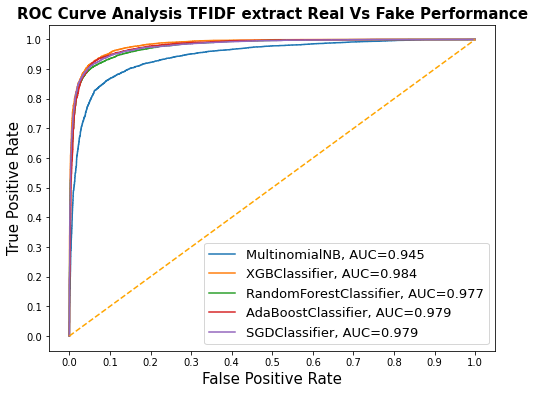

In [ ]:
print()
print("*"*36)

makeROC([TFIDFNB, TFIDFXGB, TFIDFRF, TFIDFADA, TFIDFSGD],"TFIDF extract Real Vs Fake Performance", Test_X, Test_Y)

## Complete combined classification

In [ ]:
dftopiccleaned = dftopic.drop(['neg'], axis = 1)
dfoverall = pd.concat([dftopiccleaned, dfemotion], axis=1)

#In case any columns are duplicated
#dfoverall = dfoverall.loc[:,~dfoverall.columns.duplicated()]

Train_X_overall, Test_X_overall, Train_Y_overall, Test_Y_overall = model_selection.train_test_split(dfoverall,save_y,train_size= 0.4, stratify=save_y, random_state=0)

### Complete Data Optimization

In [ ]:
print("*"*36)
print("SGD Optimization")
SGD = SGDClassifier(loss='log', penalty='l2', alpha=1e-3, n_iter_no_change=5)
param_dist = {
    'penalty': ['elasticnet','l2'],
    'alpha': [10 ** x for x in range(-6, 1)],
    'l1_ratio': [0, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1],
}
n_iter_search = 20
randomsearchmethod(SGD,param_dist, n_iter_search, Train_X_overall,Train_Y_overall)


************************************
SGD Optimization
Model with rank: 1
Mean validation score: 0.842 (std: 0.020)
Parameters: {'penalty': 'elasticnet', 'l1_ratio': 1, 'alpha': 0.001}

Model with rank: 2
Mean validation score: 0.753 (std: 0.066)
Parameters: {'penalty': 'elasticnet', 'l1_ratio': 0.9, 'alpha': 0.001}

Model with rank: 3
Mean validation score: 0.722 (std: 0.077)
Parameters: {'penalty': 'elasticnet', 'l1_ratio': 0.9, 'alpha': 1e-05}



In [ ]:
print("*"*36)
print("ADABoost Optimization")
ADA = AdaBoostClassifier()
param_dist = {
    'learning_rate' : [0.05, 0.1, 0.2, 0.5],
    'n_estimators': [100,200,300,400],
    'base_estimator': [DecisionTreeClassifier(random_state=0, max_depth=2),DecisionTreeClassifier(random_state=0, max_depth=3)]
}
n_iter_search = 2
randomsearchmethod(ADA,param_dist, n_iter_search, Train_X_overall,Train_Y_overall)

************************************
ADABoost Optimization
Model with rank: 1
Mean validation score: 0.927 (std: 0.006)
Parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')}

Model with rank: 2
Mean validation score: 0.927 (std: 0.006)
Parameters: {'n_estimators': 300, 'learning_rate': 0.2, 'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                      

In [ ]:
#Restart this one it ran on emotion
print("*"*36)
print("Random Forest Optimization")
RF = RandomForestClassifier()
param_dist = {
    'max_depth': [30,35,40],
    'n_estimators': [110,120,130,140]
}
n_iter_search = 20
randomsearchmethod(RF,param_dist, n_iter_search, Train_X_overall,Train_Y_overall)

************************************
Random Forest Optimization


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Model with rank: 1
Mean validation score: 0.925 (std: 0.007)
Parameters: {'n_estimators': 140, 'max_depth': 30}

Model with rank: 2
Mean validation score: 0.925 (std: 0.007)
Parameters: {'n_estimators': 110, 'max_depth': 40}

Model with rank: 3
Mean validation score: 0.925 (std: 0.006)
Parameters: {'n_estimators': 140, 'max_depth': 40}



In [ ]:
print("*"*36)
print("XGBoost Optimization")
XGB = XGBClassifier()
param_dist = {
    'max_depth': [15,20,25],
    'n_estimators': [ 150, 200, 250],
    'reg_alpha': [0.05, 0.1, 0.2, 0.5]
}
n_iter_search = 2
randomsearchmethod(XGB,param_dist, n_iter_search, Train_X_overall,Train_Y_overall)

************************************
XGBoost Optimization
Model with rank: 1
Mean validation score: 0.937 (std: 0.006)
Parameters: {'reg_alpha': 0.1, 'n_estimators': 150, 'max_depth': 25}

Model with rank: 2
Mean validation score: 0.937 (std: 0.005)
Parameters: {'reg_alpha': 0.5, 'n_estimators': 150, 'max_depth': 25}



### Complete Data Saving Fitted Models

In [ ]:
# replace ngram_range = (1,2) for bigram
OverallNB = MultinomialNB().fit(Train_X_Topic,Train_Y_Topic)

OverallSGD = SGDClassifier(loss='log', penalty= 'elasticnet', l1_ratio= 0.1, alpha= 0.0001, n_iter_no_change=5).fit(Train_X_overall,Train_Y_overall)

OverallADA = AdaBoostClassifier(n_estimators= 300, learning_rate= 0.1, base_estimator= DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,)).fit(Train_X_overall,Train_Y_overall)

OverallRF = RandomForestClassifier(n_estimators=140, max_depth=30, random_state=0).fit(Train_X_overall,Train_Y_overall)

OverallXGB = XGBClassifier(n_estimators = 200, max_depth=25, reg_alpha=0.1).fit(Train_X_overall,Train_Y_overall)

# Save to file in the current working directory
pkl_filename = "OverallNB.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(OverallNB, file)

pkl_filename = "OverallSGD.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(OverallSGD, file)

pkl_filename = "OverallADA.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(OverallADA, file)

pkl_filename = "OverallRF.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(OverallRF, file)

pkl_filename = "OverallXGB.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(OverallXGB, file)

### Complete Data Accuracy Report

In [ ]:
# Load from file
pkl_filename = "OverallNB.pkl"
with open(pkl_filename, 'rb') as file:
    OverallNB = pickle.load(file)

# Load from file
pkl_filename = "OverallSGD.pkl"
with open(pkl_filename, 'rb') as file:
    OverallSGD = pickle.load(file)

# Load from file
pkl_filename = "OverallADA.pkl"
with open(pkl_filename, 'rb') as file:
    OverallADA = pickle.load(file)

# Load from file
pkl_filename = "OverallRF.pkl"
with open(pkl_filename, 'rb') as file:
    OverallRF = pickle.load(file)

# Load from file
pkl_filename = "OverallXGB.pkl"
with open(pkl_filename, 'rb') as file:
    OverallXGB = pickle.load(file)

predictions_NB = OverallNB.predict(Test_X_overall)
# Use accuracy_score function to get the accuracy
print("****NB Report****")
print("MultinomialNB Accuracy:",metrics.accuracy_score(Test_Y_overall, predictions_NB))
print('\nClasification report:\n', classification_report(Test_Y_overall, predictions_NB))
print('\nConfussion matrix:\n',confusion_matrix(Test_Y_overall, predictions_NB)  )
print()
print("*"*36)


# predict the labels on validation dataset
predictions_SGD = OverallSGD.predict(Test_X_overall)
# Use accuracy_score function to get the accuracy
print("****SGD Report****")
print("SGD Accuracy:",metrics.accuracy_score(Test_Y_overall, predictions_SGD))
print('\nClasification report:\n', classification_report(Test_Y_overall, predictions_SGD))
print('\nConfussion matrix:\n',confusion_matrix(Test_Y_overall, predictions_SGD))
print()
print("*"*36)


predictions_ADA = OverallADA.predict(Test_X_overall)
# Use accuracy_score function to get the accuracy
print("****ADABoost Report****")
print("AdaBoostClassifier Accuracy:",metrics.accuracy_score(Test_Y_overall, predictions_ADA))
print('\nClasification report:\n', classification_report(Test_Y_overall, predictions_ADA))
print('\nConfussion matrix:\n',confusion_matrix(Test_Y_overall, predictions_ADA) )
print()
print("*"*36)


predictions_RF = OverallRF.predict(Test_X_overall)
# Use accuracy_score function to get the accuracy
print("****RF Report****")
print("RandomForest Accuracy:",metrics.accuracy_score(Test_Y_overall, predictions_RF))
print('\nClasification report:\n', classification_report(Test_Y_overall, predictions_RF))
print('\nConfussion matrix:\n',confusion_matrix(Test_Y_overall, predictions_RF)  )
print()
print("*"*36)


predictions_XGB = OverallXGB.predict(Test_X_overall)
# Use accuracy_score function to get the accuracy
print("****XGB Report****")
print("XGBoost Accuracy:",metrics.accuracy_score(Test_Y_overall, predictions_XGB))
print('\nClasification report:\n', classification_report(Test_Y_overall, predictions_XGB))
print('\nConfussion matrix:\n',confusion_matrix(Test_Y_overall, predictions_XGB)  )

****NB Report****
MultinomialNB Accuracy: 0.8335979676087647

Clasification report:
               precision    recall  f1-score   support

           0       0.79      0.87      0.83      5893
           1       0.87      0.80      0.84      6703

    accuracy                           0.83     12596
   macro avg       0.83      0.84      0.83     12596
weighted avg       0.84      0.83      0.83     12596


Confussion matrix:
 [[5117  776]
 [1320 5383]]

************************************
****SGD Report****
SGD Accuracy: 0.776595744680851

Clasification report:
               precision    recall  f1-score   support

           0       0.82      0.66      0.74      5893
           1       0.75      0.88      0.81      6703

    accuracy                           0.78     12596
   macro avg       0.79      0.77      0.77     12596
weighted avg       0.78      0.78      0.77     12596


Confussion matrix:
 [[3915 1978]
 [ 836 5867]]

************************************
****ADABoost R

### Overall ROC Comparison


************************************


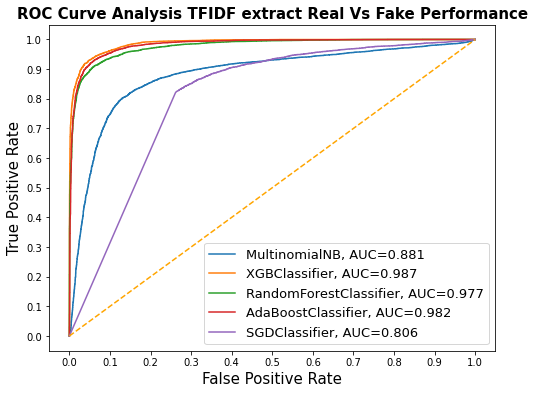

In [ ]:
print()
print("*"*36)

makeROC([OverallNB, OverallXGB, OverallRF, OverallADA, OverallSGD],"TFIDF extract Real Vs Fake Performance", Test_X_overall, Test_Y_overall)

# Testing classifiers on Alternate Domains

In [ ]:
#create Sentiment dataset
dfemotionEntertainment = pd.read_excel("sample_data/Entertainment text + Sentiment Data.xlsx")
dfEntertainment = dfemotionEntertainment['text_x']
dfEntertainmentY = dfemotionEntertainment['label_y']
dfemotionEntertainment = dfemotionEntertainment.drop(['text_x','title_x','Unnamed: 0','index','label_y',':','(',')','group_c','PRP','NNP','group_m'], axis=1)

#Split text set to 20k rows from original extract
Train_X_Entertainment, Test_X_Entertainment, Train_Y_Entertainment, Test_Y_Entertainment = model_selection.train_test_split(df['text'],df['label'],train_size= 0.45, stratify=df['label'], random_state=0)

#TFIDF Vectorize New Sample Set with trained vectorizer from old domain extract
fulllist = []
for i in Train_X_Entertainment:
    fulllist.append(i)

Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(fulllist)
AlternateTrain_X_Tfidf = Tfidf_vect.transform(dfEntertainment)

#Convert to dataframe
Entertainment_Train_X_df = pd.DataFrame(AlternateTrain_X_Tfidf.toarray(), columns=Tfidf_vect.get_feature_names())

#Create Topic Entertainment DF
dftopicEntertainment = pd.read_excel("sample_data/topic_distribution_14_entertainment.xlsx")
dftopicEntertainment = dftopicEntertainment.drop(['Unnamed: 0','Text'], axis=1)
dftopicEntertainment = pd.concat([dftopicEntertainment, Entertainment_Train_X_df], axis=1)

#Create Overall Entertainment Dataset
Entertainmentdftopiccleaned = dftopicEntertainment.drop(['neg'], axis = 1)
dfoverallEntertainment = pd.concat([Entertainmentdftopiccleaned, dfemotionEntertainment], axis=1)

## Topic Model Loading and prediction

In [ ]:
# Load from file
pkl_filename = "TopicTFIDFNB.pkl"
with open(pkl_filename, 'rb') as file:
    TopicNB = pickle.load(file)

# Load from file
pkl_filename = "TopicTFIDFSGD.pkl"
with open(pkl_filename, 'rb') as file:
    TopicSGD = pickle.load(file)

# Load from file
pkl_filename = "TopicTFIDFADA.pkl"
with open(pkl_filename, 'rb') as file:
    TopicADA = pickle.load(file)

# Load from file
pkl_filename = "TopicTFIDFRF.pkl"
with open(pkl_filename, 'rb') as file:
    TopicRF = pickle.load(file)

# Load from file
pkl_filename = "TopicTFIDFXGB.pkl"
with open(pkl_filename, 'rb') as file:
    TopicXGB = pickle.load(file)

In [ ]:
# replace ngram_range = (1,2) for bigram
predictions_NB = TopicNB.predict(dftopicEntertainment)
# Use accuracy_score function to get the accuracy
print("****NB Report****")
print("MultinomialNB Accuracy:",metrics.accuracy_score(dfEntertainmentY, predictions_NB))
print('\nClasification report:\n', classification_report(dfEntertainmentY, predictions_NB))
print('\nConfussion matrix:\n',confusion_matrix(dfEntertainmentY, predictions_NB)  )
print()
print("*"*36)

# predict the labels on validation dataset
predictions_SGD = TopicSGD.predict(dftopicEntertainment)
# Use accuracy_score function to get the accuracy
print("****SGD Report****")
print("SGD Accuracy:",metrics.accuracy_score(dfEntertainmentY, predictions_SGD))
print('\nClasification report:\n', classification_report(dfEntertainmentY, predictions_SGD))
print('\nConfussion matrix:\n',confusion_matrix(dfEntertainmentY, predictions_SGD))
print()
print("*"*36)


predictions_ADA = TopicADA.predict(dftopicEntertainment)
# Use accuracy_score function to get the accuracy
print("****ADABoost Report****")
print("AdaBoostClassifier Accuracy:",metrics.accuracy_score(dfEntertainmentY, predictions_ADA))
print('\nClasification report:\n', classification_report(dfEntertainmentY, predictions_ADA))
print('\nConfussion matrix:\n',confusion_matrix(dfEntertainmentY, predictions_ADA) )
print()
print("*"*36)


predictions_RF = TopicRF.predict(dftopicEntertainment)
# Use accuracy_score function to get the accuracy
print("****RF Report****")
print("RandomForest Accuracy:",metrics.accuracy_score(dfEntertainmentY, predictions_RF))
print('\nClasification report:\n', classification_report(dfEntertainmentY, predictions_RF))
print('\nConfussion matrix:\n',confusion_matrix(dfEntertainmentY, predictions_RF)  )
print()
print("*"*36)


predictions_XGB = TopicXGB.predict(dftopicEntertainment)
# Use accuracy_score function to get the accuracy
print("****XGB Report****")
print("XGBoost Accuracy:",metrics.accuracy_score(dfEntertainmentY, predictions_XGB))
print('\nClasification report:\n', classification_report(dfEntertainmentY, predictions_XGB))
print('\nConfussion matrix:\n',confusion_matrix(dfEntertainmentY, predictions_XGB)  )

****NB Report****
MultinomialNB Accuracy: 0.6

Clasification report:
               precision    recall  f1-score   support

           0       0.56      0.90      0.69        50
           1       0.75      0.30      0.43        50

    accuracy                           0.60       100
   macro avg       0.66      0.60      0.56       100
weighted avg       0.66      0.60      0.56       100


Confussion matrix:
 [[45  5]
 [35 15]]

************************************
****SGD Report****
SGD Accuracy: 0.65

Clasification report:
               precision    recall  f1-score   support

           0       0.60      0.92      0.72        50
           1       0.83      0.38      0.52        50

    accuracy                           0.65       100
   macro avg       0.71      0.65      0.62       100
weighted avg       0.71      0.65      0.62       100


Confussion matrix:
 [[46  4]
 [31 19]]

************************************
****ADABoost Report****
AdaBoostClassifier Accuracy: 0.63


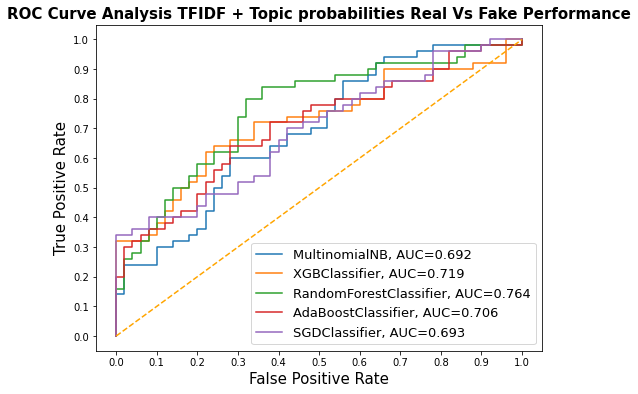

In [ ]:
makeROC([TopicNB, TopicXGB, TopicRF, TopicADA, TopicSGD],"TFIDF + Topic probabilities Real Vs Fake Performance",dftopicEntertainment, dfEntertainmentY)

## sentiment Model Loading and prediction

In [ ]:
# Load from file
pkl_filename = "EmotionNB.pkl"
with open(pkl_filename, 'rb') as file:
    EmotionNB = pickle.load(file)

# Load from file
pkl_filename = "EmotionSGD.pkl"
with open(pkl_filename, 'rb') as file:
    EmotionSGD = pickle.load(file)

# Load from file
pkl_filename = "EmotionADA.pkl"
with open(pkl_filename, 'rb') as file:
    EmotionADA = pickle.load(file)

# Load from file
pkl_filename = "EmotionRF.pkl"
with open(pkl_filename, 'rb') as file:
    EmotionRF = pickle.load(file)

# Load from file
pkl_filename = "EmotionXGB.pkl"
with open(pkl_filename, 'rb') as file:
    EmotionXGB = pickle.load(file)

In [ ]:
# replace ngram_range = (1,2) for bigram
predictions_NB = EmotionNB.predict(dfemotionEntertainment)
# Use accuracy_score function to get the accuracy
print("****NB Report****")
print("MultinomialNB Accuracy:",metrics.accuracy_score(dfEntertainmentY, predictions_NB))
print('\nClasification report:\n', classification_report(dfEntertainmentY, predictions_NB))
print('\nConfussion matrix:\n',confusion_matrix(dfEntertainmentY, predictions_NB)  )
print()
print("*"*36)


# predict the labels on validation dataset
predictions_SGD = EmotionSGD.predict(dfemotionEntertainment)
# Use accuracy_score function to get the accuracy
print("****SGD Report****")
print("SGD Accuracy:",metrics.accuracy_score(dfEntertainmentY, predictions_SGD))
print('\nClasification report:\n', classification_report(dfEntertainmentY, predictions_SGD))
print('\nConfussion matrix:\n',confusion_matrix(dfEntertainmentY, predictions_SGD))
print()
print("*"*36)


predictions_ADA = EmotionADA.predict(dfemotionEntertainment)
# Use accuracy_score function to get the accuracy
print("****ADABoost Report****")
print("AdaBoostClassifier Accuracy:",metrics.accuracy_score(dfEntertainmentY, predictions_ADA))
print('\nClasification report:\n', classification_report(dfEntertainmentY, predictions_ADA))
print('\nConfussion matrix:\n',confusion_matrix(dfEntertainmentY, predictions_ADA) )
print()
print("*"*36)


predictions_RF = EmotionRF.predict(dfemotionEntertainment)
# Use accuracy_score function to get the accuracy
print("****RF Report****")
print("RandomForest Accuracy:",metrics.accuracy_score(dfEntertainmentY, predictions_RF))
print('\nClasification report:\n', classification_report(dfEntertainmentY, predictions_RF))
print('\nConfussion matrix:\n',confusion_matrix(dfEntertainmentY, predictions_RF)  )
print()
print("*"*36)


predictions_XGB = EmotionXGB.predict(dfemotionEntertainment)
# Use accuracy_score function to get the accuracy
print("****XGB Report****")
print("XGBoost Accuracy:",metrics.accuracy_score(dfEntertainmentY, predictions_XGB))
print('\nClasification report:\n', classification_report(dfEntertainmentY, predictions_XGB))
print('\nConfussion matrix:\n',confusion_matrix(dfEntertainmentY, predictions_XGB)  )

****NB Report****
MultinomialNB Accuracy: 0.57

Clasification report:
               precision    recall  f1-score   support

           0       0.56      0.64      0.60        50
           1       0.58      0.50      0.54        50

    accuracy                           0.57       100
   macro avg       0.57      0.57      0.57       100
weighted avg       0.57      0.57      0.57       100


Confussion matrix:
 [[32 18]
 [25 25]]

************************************
****SGD Report****
SGD Accuracy: 0.55

Clasification report:
               precision    recall  f1-score   support

           0       0.53      0.98      0.69        50
           1       0.86      0.12      0.21        50

    accuracy                           0.55       100
   macro avg       0.69      0.55      0.45       100
weighted avg       0.69      0.55      0.45       100


Confussion matrix:
 [[49  1]
 [44  6]]

************************************
****ADABoost Report****
AdaBoostClassifier Accuracy: 0.69

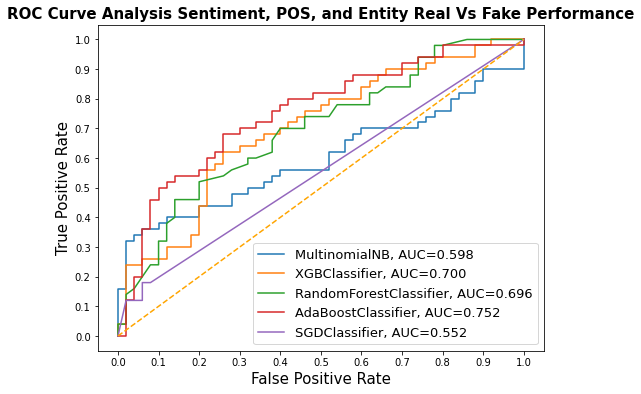

In [ ]:
makeROC([ EmotionNB, EmotionXGB, EmotionRF, EmotionADA, EmotionSGD],"Sentiment, POS, and Entity Real Vs Fake Performance", dfemotionEntertainment, dfEntertainmentY)

## TFIDF Model Loading and prediction

In [ ]:
# Load from file
pkl_filename = "BaseExtractTFIDFNB.pkl"
with open(pkl_filename, 'rb') as file:
    TFIDFNB = pickle.load(file)

# Load from file
pkl_filename = "BaseExtractTFIDFSGD.pkl"
with open(pkl_filename, 'rb') as file:
    TFIDFSGD = pickle.load(file)

# Load from file
pkl_filename = "BaseExtractTFIDFADA.pkl"
with open(pkl_filename, 'rb') as file:
    TFIDFADA = pickle.load(file)

# Load from file
pkl_filename = "BaseExtractTFIDFRF.pkl"
with open(pkl_filename, 'rb') as file:
    TFIDFRF = pickle.load(file)

# Load from file
pkl_filename = "BaseExtractTFIDFXGB.pkl"
with open(pkl_filename, 'rb') as file:
    TFIDFXGB = pickle.load(file)

In [ ]:
# replace ngram_range = (1,2) for bigram
predictions_NB = TFIDFNB.predict(Entertainment_Train_X_df)
# Use accuracy_score function to get the accuracy
print("****NB Report****")
print("MultinomialNB Accuracy:",metrics.accuracy_score(dfEntertainmentY, predictions_NB))
print('\nClasification report:\n', classification_report(dfEntertainmentY, predictions_NB))
print('\nConfussion matrix:\n',confusion_matrix(dfEntertainmentY, predictions_NB)  )
print()
print("*"*36)


# predict the labels on validation dataset
predictions_SGD = TFIDFSGD.predict(Entertainment_Train_X_df)
# Use accuracy_score function to get the accuracy
print("****SGD Report****")
print("SGD Accuracy:",metrics.accuracy_score(dfEntertainmentY, predictions_SGD))
print('\nClasification report:\n', classification_report(dfEntertainmentY, predictions_SGD))
print('\nConfussion matrix:\n',confusion_matrix(dfEntertainmentY, predictions_SGD))
print()
print("*"*36)


predictions_ADA = TFIDFADA.predict(Entertainment_Train_X_df)
# Use accuracy_score function to get the accuracy
print("****ADABoost Report****")
print("AdaBoostClassifier Accuracy:",metrics.accuracy_score(dfEntertainmentY, predictions_ADA))
print('\nClasification report:\n', classification_report(dfEntertainmentY, predictions_ADA))
print('\nConfussion matrix:\n',confusion_matrix(dfEntertainmentY, predictions_ADA) )
print()
print("*"*36)


predictions_RF = TFIDFRF.predict(Entertainment_Train_X_df)
# Use accuracy_score function to get the accuracy
print("****RF Report****")
print("RandomForest Accuracy:",metrics.accuracy_score(dfEntertainmentY, predictions_RF))
print('\nClasification report:\n', classification_report(dfEntertainmentY, predictions_RF))
print('\nConfussion matrix:\n',confusion_matrix(dfEntertainmentY, predictions_RF)  )
print()
print("*"*36)


predictions_XGB = TFIDFXGB.predict(Entertainment_Train_X_df)
# Use accuracy_score function to get the accuracy
print("****XGB Report****")
print("XGBoost Accuracy:",metrics.accuracy_score(dfEntertainmentY, predictions_XGB))
print('\nClasification report:\n', classification_report(dfEntertainmentY, predictions_XGB))
print('\nConfussion matrix:\n',confusion_matrix(dfEntertainmentY, predictions_XGB)  )

****NB Report****
MultinomialNB Accuracy: 0.6

Clasification report:
               precision    recall  f1-score   support

           0       0.56      0.90      0.69        50
           1       0.75      0.30      0.43        50

    accuracy                           0.60       100
   macro avg       0.66      0.60      0.56       100
weighted avg       0.66      0.60      0.56       100


Confussion matrix:
 [[45  5]
 [35 15]]

************************************
****SGD Report****
SGD Accuracy: 0.67

Clasification report:
               precision    recall  f1-score   support

           0       0.61      0.96      0.74        50
           1       0.90      0.38      0.54        50

    accuracy                           0.67       100
   macro avg       0.76      0.67      0.64       100
weighted avg       0.76      0.67      0.64       100


Confussion matrix:
 [[48  2]
 [31 19]]

************************************
****ADABoost Report****
AdaBoostClassifier Accuracy: 0.74



************************************


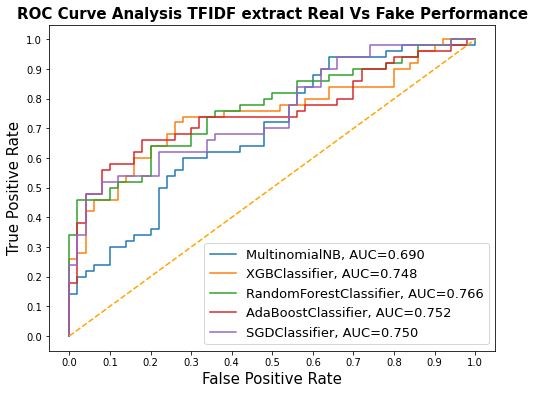

In [ ]:
print()
print("*"*36)

makeROC([TFIDFNB, TFIDFXGB, TFIDFRF, TFIDFADA, TFIDFSGD],"TFIDF extract Real Vs Fake Performance",Entertainment_Train_X_df, dfEntertainmentY)

## Overall Model Loading and prediction

In [ ]:
# Load from file
pkl_filename = "OverallNB.pkl"
with open(pkl_filename, 'rb') as file:
    OverallNB = pickle.load(file)

# Load from file
pkl_filename = "OverallSGD.pkl"
with open(pkl_filename, 'rb') as file:
    OverallSGD = pickle.load(file)

# Load from file
pkl_filename = "OverallADA.pkl"
with open(pkl_filename, 'rb') as file:
    OverallADA = pickle.load(file)

# Load from file
pkl_filename = "OverallRF.pkl"
with open(pkl_filename, 'rb') as file:
    OverallRF = pickle.load(file)

# Load from file
pkl_filename = "OverallXGB.pkl"
with open(pkl_filename, 'rb') as file:
    OverallXGB = pickle.load(file)

predictions_NB = OverallNB.predict(dfoverallEntertainment)
# Use accuracy_score function to get the accuracy
print("****NB Report****")
print("MultinomialNB Accuracy:",metrics.accuracy_score(dfEntertainmentY, predictions_NB))
print('\nClasification report:\n', classification_report(dfEntertainmentY, predictions_NB))
print('\nConfussion matrix:\n',confusion_matrix(dfEntertainmentY, predictions_NB)  )
print()
print("*"*36)


# predict the labels on validation dataset
predictions_SGD = OverallSGD.predict(dfoverallEntertainment)
# Use accuracy_score function to get the accuracy
print("****SGD Report****")
print("SGD Accuracy:",metrics.accuracy_score(dfEntertainmentY, predictions_SGD))
print('\nClasification report:\n', classification_report(dfEntertainmentY, predictions_SGD))
print('\nConfussion matrix:\n',confusion_matrix(dfEntertainmentY, predictions_SGD))
print()
print("*"*36)


predictions_ADA = OverallADA.predict(dfoverallEntertainment)
# Use accuracy_score function to get the accuracy
print("****ADABoost Report****")
print("AdaBoostClassifier Accuracy:",metrics.accuracy_score(dfEntertainmentY, predictions_ADA))
print('\nClasification report:\n', classification_report(dfEntertainmentY, predictions_ADA))
print('\nConfussion matrix:\n',confusion_matrix(dfEntertainmentY, predictions_ADA) )
print()
print("*"*36)


predictions_RF = OverallRF.predict(dfoverallEntertainment)
# Use accuracy_score function to get the accuracy
print("****RF Report****")
print("RandomForest Accuracy:",metrics.accuracy_score(dfEntertainmentY, predictions_RF))
print('\nClasification report:\n', classification_report(dfEntertainmentY, predictions_RF))
print('\nConfussion matrix:\n',confusion_matrix(dfEntertainmentY, predictions_RF)  )
print()
print("*"*36)


predictions_XGB = OverallXGB.predict(dfoverallEntertainment)
# Use accuracy_score function to get the accuracy
print("****XGB Report****")
print("XGBoost Accuracy:",metrics.accuracy_score(dfEntertainmentY, predictions_XGB))
print('\nClasification report:\n', classification_report(dfEntertainmentY, predictions_XGB))
print('\nConfussion matrix:\n',confusion_matrix(dfEntertainmentY, predictions_XGB)  )

****NB Report****
MultinomialNB Accuracy: 0.63

Clasification report:
               precision    recall  f1-score   support

           0       0.59      0.84      0.69        50
           1       0.72      0.42      0.53        50

    accuracy                           0.63       100
   macro avg       0.66      0.63      0.61       100
weighted avg       0.66      0.63      0.61       100


Confussion matrix:
 [[42  8]
 [29 21]]

************************************
****SGD Report****
SGD Accuracy: 0.67

Clasification report:
               precision    recall  f1-score   support

           0       0.71      0.58      0.64        50
           1       0.64      0.76      0.70        50

    accuracy                           0.67       100
   macro avg       0.68      0.67      0.67       100
weighted avg       0.68      0.67      0.67       100


Confussion matrix:
 [[29 21]
 [12 38]]

************************************
****ADABoost Report****
AdaBoostClassifier Accuracy: 0.63


************************************


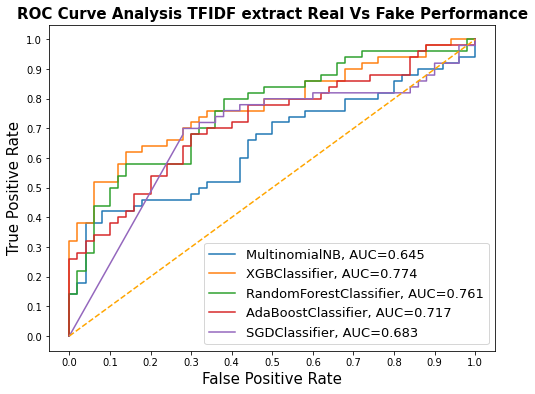

In [ ]:
print()
print("*"*36)

makeROC([OverallNB, OverallXGB, OverallRF, OverallADA, OverallSGD],"TFIDF extract Real Vs Fake Performance",dfoverallEntertainment, dfEntertainmentY)

# For Fast Text Representation

In [ ]:
tfrom gensim.models.fasttext import FastText
import time

all_docs = []
for i in documents:
    for j in i:
        all_docs.append(i[0])
        
# parameters to train fast text
embedding_size = 300 #Dimensionality of the word vectors.
window_size = 5 #The maximum distance between the current and predicted word within a sentence. Captures context
min_word = 5 #The model ignores all words with total frequency lower than this.
down_sampling = 1e-2  #The threshold for configuring which higher-frequency words are randomly downsampled

# This is to track processing time
start_time = time.time()

ft_model = FastText(all_docs,
                      size=embedding_size,
                      window=window_size,
                      min_count=min_word,
                      sample=down_sampling,
                      sg=0, # put 1 if you want to use skip-gram, look into the documentation for other variables
                      iter=100)

print("Embedding Completed! Time taken: %s seconds\n" % (time.time() - start_time))

print(ft_model)

In [ ]:
#The below code is a minor modification of the feature selector and a repeat of the above code
import numpy as np

def embedded_document_features(document): 
    document_words = set(document)
    features = {}
    for word in document_words:
        #word=word.lower()
        #if word in dictionary:
        features['contains({})'.format(word)] = np.mean(ft_model.wv[word]) # the average vector value
    return features

featuresets = [(embedded_document_features(d), c) for (d,c) in documents]
train_set, test_set = featuresets[100:], featuresets[:100]
classifier = nltk.NaiveBayesClassifier.train(train_set)

print(nltk.classify.accuracy(classifier, test_set))
classifier.show_most_informative_features(5)

In [ ]:
# Compare the results with the previous results and see if there are any difference.
# Most of the codes can be further simplified if we are using functions
# Note that the we also did not do any pre-processing steps

test_result = []
gold_result = []

for i in range(len(test_set)):
    test_result.append(classifier.classify(test_set[i][0]))
    gold_result.append(test_set[i][1])

print('\nClasification report:\n', classification_report(gold_result, test_result))
print('\nConfussion matrix:\n',confusion_matrix(gold_result, test_result)  )